In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios,
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging,
                            path_CLUSTER_results,
                            file_tas
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.signal import detrend

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

## Load Data

a. GMT Data

In [2]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

b. GDP Data

In [3]:
gdp_df   = pd.read_csv(cset.file_jps).loc[:, ['iso', 'scen', 'run', 'year', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Refp5', 'scen'] = 'Ref1p5'
gdp_df['run'] = [f.split('_')[-1] for f in gdp_df['run']]
gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_df.reset_index(drop = True, inplace = True)

## Clustering Analysis

In [4]:
# Assuming your DataFrame is named df
# Ensure the data is sorted by scenario, iso, run, and year
gdp_df = gdp_df.sort_values(by=['scen', 'iso', 'run', 'year'])

# Pivot the DataFrame to get the correct shape (scen, iso, run, year)
# We use a multi-index pivot for scen, iso, and run, with year as columns
pivot_df = gdp_df.pivot_table(index=['scen', 'iso', 'run'], columns='year', values='SSP2_clim')

# Define the dimensions
n_scenarios = 10  # Number of scenarios
n_isos = 157  # Number of countries
n_runs = 100  # Number of runs per scenario
n_time_steps = 86  # Number of years/time steps

# Reshape the DataFrame into a 4D numpy array (scen, iso, run, year)
gdp_clim_array = pivot_df.values.reshape(n_scenarios, n_isos, n_runs, n_time_steps)
gdp_clim_std = StandardScaler().fit_transform(gdp_clim_array.reshape(-1, n_time_steps).T)

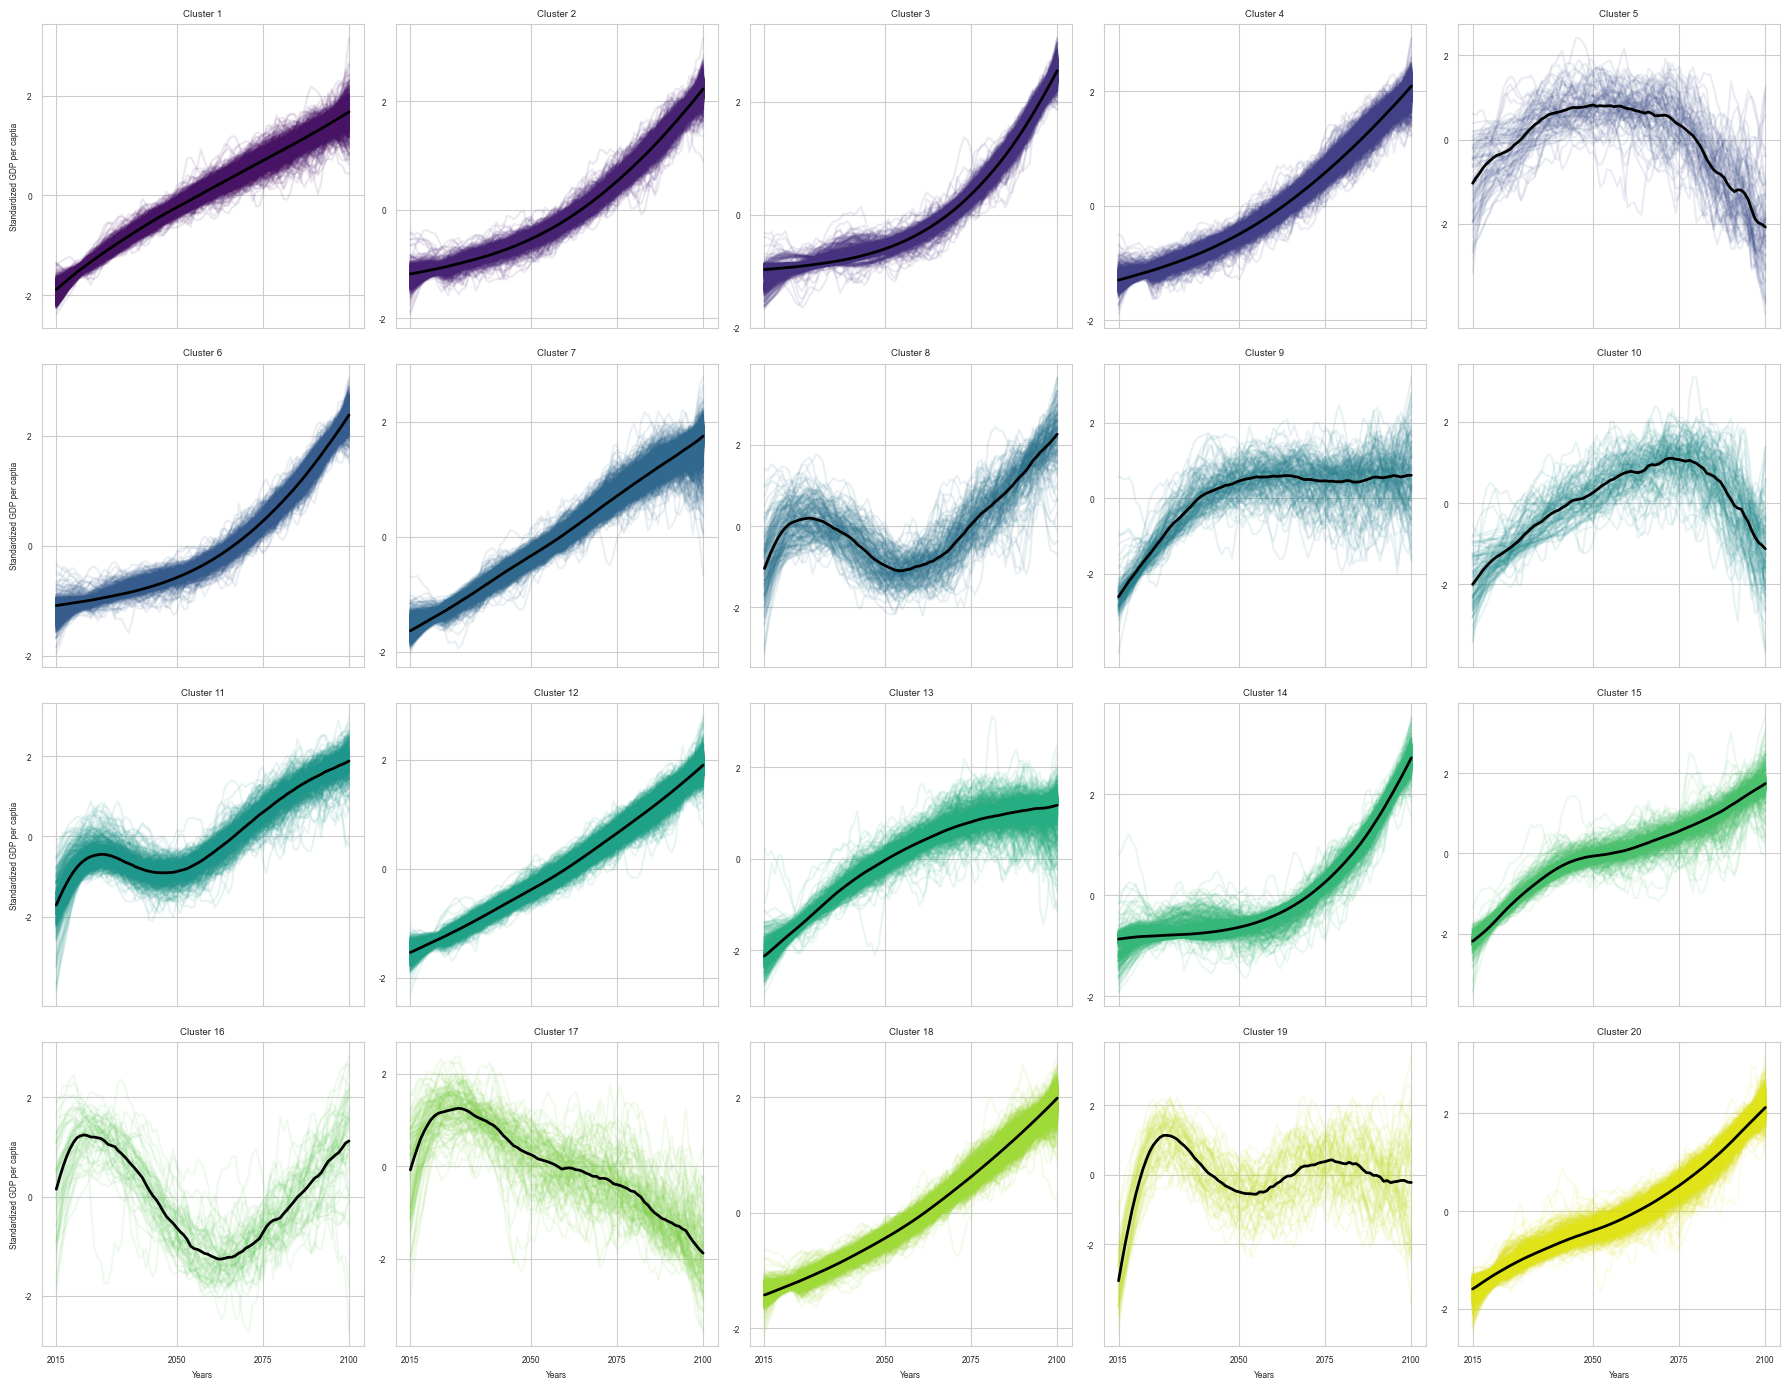

In [5]:
n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(gdp_clim_std.T)
labels = kmeans.labels_
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(4, 5, figsize = (18, 14))
    colors = sns.color_palette('viridis', n_clusters)
    for i, ax in enumerate(axes.flatten()):
        ax.plot(gdp_clim_std[:, labels == i], color =  colors[i], alpha = 0.1)
        ax.plot(gdp_clim_std[:, labels == i].mean(axis = 1), color = 'black', linewidth = 2)
        ax.set_title(f'Cluster {i+1}', fontsize = labelsize_large)
        if i%5 == 0:
            ax.set_ylabel('Standardized GDP per captia', fontsize = labelsize_medium)
        ax.set_yticks([-2, 0, 2], [-2, 0, 2], fontsize = labelsize_medium)
        if i > 14:
            ax.set_xlabel('Years', fontsize = labelsize_medium)
            ax.set_xticks([0, 35, 60, 85], [2015, 2050, 2075, 2100], fontsize = labelsize_medium)
        else: 
            ax.set_xticks([0, 35, 60, 85], [])
    plt.tight_layout()
    Path(cset.path_GRAPHICS / 'appendix').mkdir(exist_ok = True, parents = True)
    plt.savefig(cset.path_GRAPHICS / 'appendix' / 'gdp_clusters.png', dpi = 600)
    plt.show()

## Devide all GDP trajectories into a growth category 

- categories: growth, stagnating growth, growth reversal, inconclusive 
- assign every trajectory a lable 

In [6]:
# Define a function to apply a rolling mean over the second dimension
def rolling_mean_2d(array, window_size):
    # Create an empty array to store the results, same shape as input
    result = np.empty_like(array)

    # Loop over the first dimension (e.g., countries)
    for i in range(array.shape[0]):
        # Apply a rolling mean over the second dimension (e.g., years)
        result[i, :] = np.convolve(array[i, :], np.ones(window_size)/window_size, mode='same')

    return result
window_size = 5
gdp_agg_std = rolling_mean_2d(gdp_clim_std.T, window_size).T[2:-2,:]

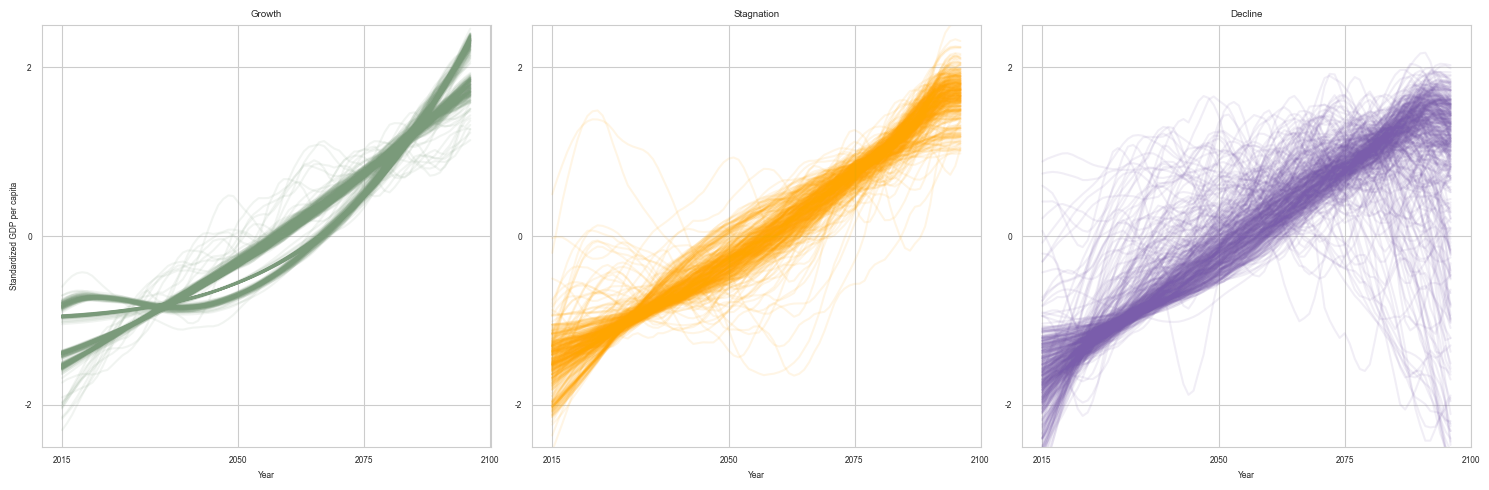

In [7]:
colors_clusters = colors = ['#7A9A7A', 
                            'orange', 
                            '#7A5DAB']
cluster_labels = ['Growth', 'Stagnation', 'Decline']
tol = 0.005
gdp_slope = np.diff(gdp_agg_std, axis = 0)
idx_growth     = np.argwhere(gdp_agg_std[-1,:] > (1+tol)*np.max(gdp_agg_std[:-2,:], axis = 0)).flatten()
idx_stagnation = np.argwhere((gdp_agg_std[-1,:] > np.max(gdp_agg_std[:-2,:], axis = 0)) & (gdp_agg_std[-1,:] <= (1+tol)*np.max(gdp_agg_std[:-2,:], axis = 0))).flatten()
idx_nogrowth   = np.argwhere(gdp_agg_std[-1,:] <= np.max(gdp_agg_std[:-2,:], axis = 0)).flatten()

with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,3, figsize = (15, 5))
    for i, idx in enumerate([idx_growth, idx_stagnation, idx_nogrowth]): 
        ax = axes[i]
        ax.plot(gdp_agg_std[:, idx[:400]], color = colors_clusters[i], alpha = 0.1)
        ax.set_xticks([0, 35, 60, 85], [2015, 2050, 2075, 2100], fontsize = labelsize_medium)
        ax.set_yticks([-2, 0, 2], [-2, 0, 2], fontsize = labelsize_medium)
        ax.set_title(cluster_labels[i], fontsize = labelsize_large)
        ax.set_ylim(-2.5,2.5)
        if i == 0:
            ax.set_ylabel('Standardized GDP per capita', fontsize = labelsize_medium)
        ax.set_xlabel('Year', fontsize = labelsize_medium)
    fig.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / 'appendix' / 'gdp_clusters_defined.pdf', dpi = 600)
    plt.show()

In [8]:
# store growth category pandas dataframe
growth_category_array = np.array(['empty']*(n_scenarios*n_runs*n_isos))
growth_category_array[idx_growth] = 'growth'
growth_category_array[idx_stagnation] = 'stagnation'
growth_category_array[idx_nogrowth] = 'nogrowth'
# growth_category_array = growth_category_array.T.reshape(n_scenarios, n_isos, n_runs, n_time_steps)
tmp = pivot_df.reset_index().copy()
classification_df = pd.DataFrame(index = np.arange(n_scenarios*n_runs*n_isos), 
                                 columns = tmp.columns[:3].values, 
                                 dtype = object)
classification_df.iloc[:, :3] = tmp.iloc[:, :3].values
classification_df.loc[:, 'category'] = growth_category_array

b. add exceedance info

In [56]:
classifier_variable = 'gmt_cum'
thrshld_str = '135'
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)
classification_df.loc[:, 'scen_run'] = classification_df.loc[:, 'scen'] + '_' + classification_df.loc[:, 'run'].astype(str)
classification_df.loc[:, classifier_variable] = gmt_char_df.loc[classification_df.scen_run.values, classifier_variable].values

c. save result

In [58]:
Path(path_CLUSTER_results).mkdir(parents=True, 
                                 exist_ok=True)
classification_df.to_csv(path_CLUSTER_results / 'growth_classification.csv')